In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import acf

from IPython.display import display, HTML
display(HTML(""" <style> .output {display: center; align-items: left; text-align: center; justify-content: center; } </style> """))

In [5]:
#DESCARGA DE DATOS
data = pd.read_excel('Generación Intermitente de la GCROC 2013-2019.xlsx', header=1)
data.head()

,Unnamed: 0,día de la semana,fecha,hora,GICIE301,GICIE302,GICIE303,GICIE304,GICIE305,GICIS306,GICIS307,GICIS308,GICIS309,GICIS310,GICIS311,GICIS312,GICIS313,GICIS314,GICIS315,GICIS316
0,NaN,Jueves,2013-11-14,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaT,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaT,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaT,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaT,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#LIMPIEZA DE DATOS
#Se elimina el primer día (14-11-2013) ya que muchas horas no tienen registro.
data = data.reset_index(level=None)
data = data.drop(range(0, 24),axis=0)
data = data.set_index(data['fecha'])

In [7]:
columns = ['GICIE301','GICIE302', 'GICIE303', 'GICIE304', 'GICIE305', 'GICIS306', 'GICIS307','GICIS308', 
           'GICIS309', 'GICIS310', 'GICIS311', 'GICIS312', 'GICIS313','GICIS314', 'GICIS315', 'GICIS316']

In [8]:
def mape(forecast, actual):
    return np.mean(np.abs((forecast - actual)/actual))  # MAPE

In [9]:
def AIC_accuracy(train,test):
    fcc = []
    for i in range(1,25):
        data = train['Hora '+str(i)].dropna()
        model = pm.auto_arima(data.values, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=5, max_q=4, # maximum p and q
                          m=1,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality
                          start_P=0, 
                          D=0, 
                          trace=False,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
        model.fit(data.values)
        #print(model)
        #model.plot_diagnostics(figsize=(7,5))
        #plt.show()
        # Predicción
        fc, confint = model.predict(n_periods=len(test), return_conf_int=True)
        fcc.append(fc)
    return(fcc, model)

In [10]:
def mape_prom(columna):
    data2 = data[['hora',columna]]
    data2[columna] = (data[columna]+1) # para efectos de las tranformaciones logaritmicas(eliminar el 0)
    data2 = data2.dropna()
    # se separara por hora del día, ya que cada hora se comporta diferente
    xhr = pd.DataFrame() ; log = pd.DataFrame() ; rends = pd.DataFrame() ; rlogs = pd.DataFrame()
    ano,dia,hora= str(data2.index[1])[0:4], str(data2.index[1])[5:7] ,str(data2.index[1])[8:10]
    for i in range(1,25):
        hrs = [data2.iloc[j][1] for j in range(len(data2)) if data2.iloc[j][0] == i ] #pd.Series()
        xhr['Hora '+str(i)] = hrs
        log['Hora '+str(i)] = [ np.log(hrs[j]) for j in range(len(hrs))]
    xhr = xhr.set_index(pd.date_range(pd.datetime(int(ano),int(dia),int(hora)),periods=len(data2)/24))
    log = log.set_index(pd.date_range(pd.datetime(int(ano),int(dia),int(hora)),periods=len(data2)/24))
    #MODELO ARIMA
    test = (xhr.iloc[-5:,:])-1   # INFO DE TEST
    date_list = [datetime(2019, 3, 14),
             datetime(2019, 3, 15),
             datetime(2019, 3, 16),
             datetime(2019, 3, 17),
             datetime(2019, 3, 18)]
    train = log.drop(date_list) # QUITANDO TEST PARA TRAIN
    fc, model = AIC_accuracy(train,test)
    mapes = [mape(fc[i-1], np.log(test['Hora '+str(i)])) for i in range(1,25)]
    mapes = pd.DataFrame(mapes).dropna()
    mape_promedio= np.mean(mapes)
    dias = []
    for j in range(0,5):
        dias.append([np.exp([ fc[i][j] for i in range(len(fc))])][0])
    pronostico = pd.DataFrame(np.concatenate(dias))
    pronostico = pronostico.set_index(pd.date_range(pd.datetime(2019,3,14),periods=len(pronostico),freq='H'))
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(data[columna]['2019-03'], label='Datos reales')
    plt.plot(pronostico, label='pronostico')
    plt.title('Predicción vs Reales 5 dias '+columna)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    return mape_promedio, fc , model

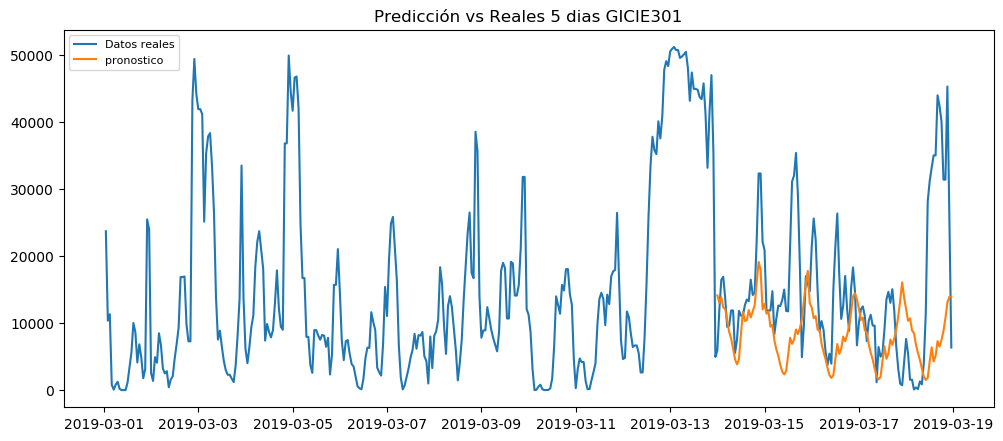

In [ ]:
mapes_prom = [mape_prom(columns[i]) for i in range(0,11)]
mapes_prom

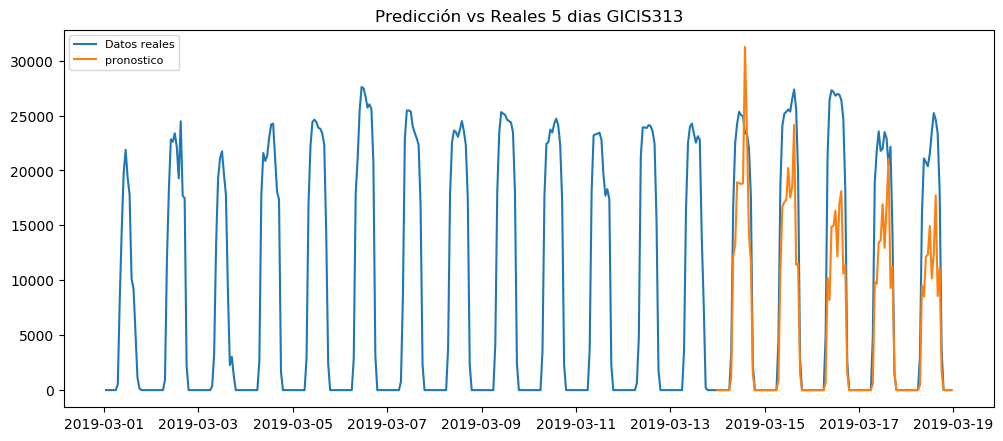

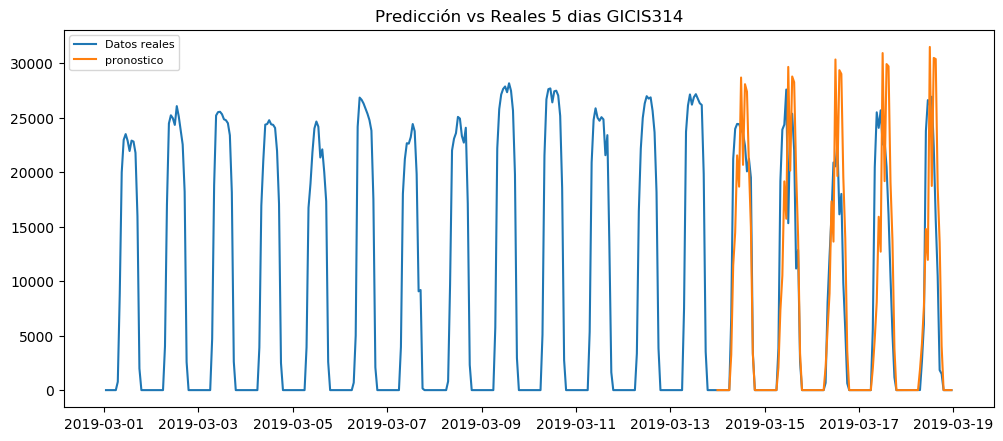

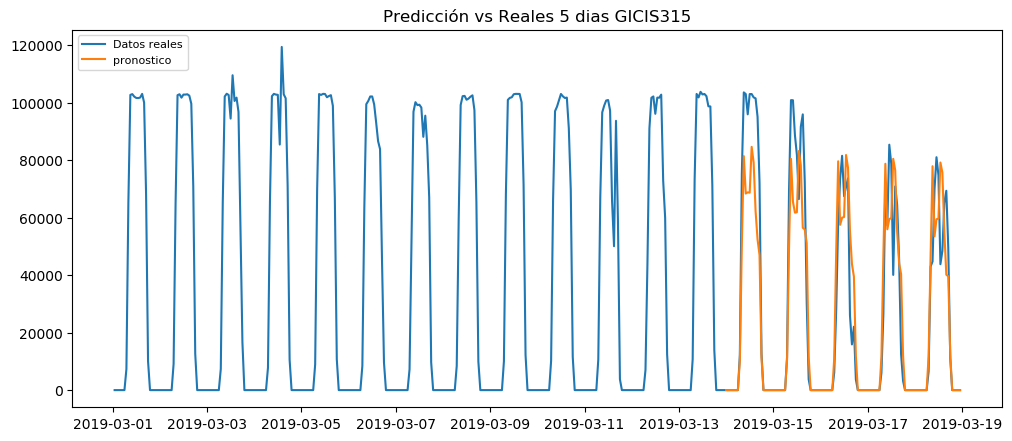

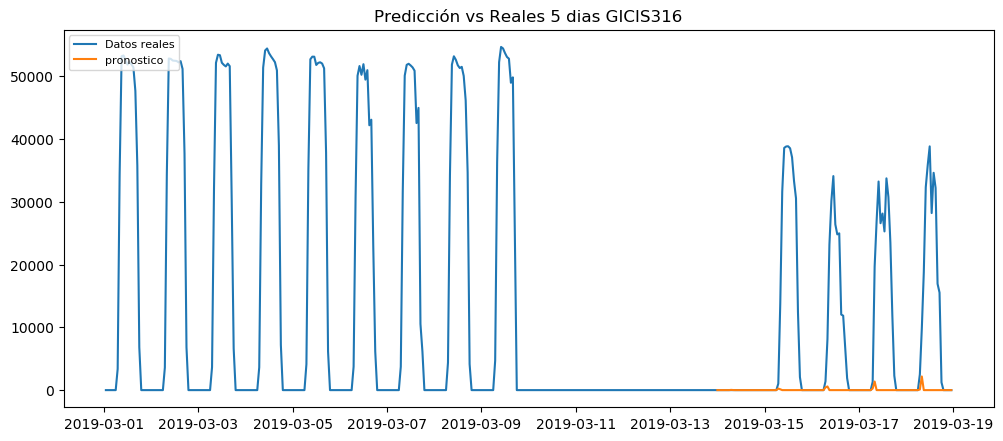

[(0    0.063892
  dtype: float64,
  [array([0.00502281, 0.00502281, 0.00502281, 0.00502281, 0.00502281]),
   array([0.00502281, 0.00502281, 0.00502281, 0.00502281, 0.00502281]),
   array([0.00502281, 0.00502281, 0.00502281, 0.00502281, 0.00502281]),
   array([0., 0., 0., 0., 0.]),
   array([0., 0., 0., 0., 0.]),
   array([0., 0., 0., 0., 0.]),
   array([0., 0., 0., 0., 0.]),
   array([7.05564239, 6.76442859, 6.52024095, 6.31548552, 6.14379467]),
   array([9.40507931, 9.2876281 , 9.23124722, 9.19480913, 9.16504056]),
   array([9.49002559, 9.72209113, 9.01255581, 9.17683134, 9.05023158]),
   array([9.84817139, 9.74824825, 9.60765086, 9.50625759, 9.40468919]),
   array([9.84446607, 9.75812999, 9.61243257, 9.51993511, 9.42028385]),
   array([9.83954657, 9.91479075, 9.70203826, 9.73575796, 9.61182936]),
   array([9.84375839, 9.77206488, 9.4072941 , 9.46886421, 9.22745125]),
   array([10.34966752,  9.8239815 ,  9.7412762 ,  9.72693455,  9.42618753]),
   array([10.05246646, 10.09151823,  9.80

In [10]:
mapes_prom2 = [mape_prom(columns[i]) for i in range(12,16)]
mapes_prom2

In [ ]:
#La unica planta que no corre es GICIS312.